In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
units_scalar = {
    'P':1e15 ,
    'T':1e12 ,
    'G':1e9 ,
    'M':1e6 ,
    'K':1e3 ,
    'm':1e-3 ,
    'u':1e-6 ,
    'n':1e-9 ,
    'p':1e-12 ,
    'f':1e-15 ,
    'a':1e-18 ,
    '%':1e-2 
}

macros = ["Data Bank", "Tag Bank"]

In [3]:
# Directory where the files are located
sweep_path = "results/collate/"

In [4]:
def numerical_sort(title):
    # Use a regular expression to find the numerical part
    match = re.search(r'^(\d+)', title)
    if match:
        return int(match.group(1))
    else:
        # Return a high value for items that don't match the pattern to move them to the end of the list
        return float('inf')

In [5]:
def collate_major_results(directory_path, reverse):
    # Regular expression pattern to match "key = content" lines with a numerical piece and units piece
    result_dict = {}

    pattern = r'^\s*-\s*(\w+)\s*=\s*([\d.]+)\s*([A-Za-z]+)\s*$'

    for filename in sorted(os.listdir(directory_path), key=numerical_sort, reverse=reverse):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory_path, filename)
            # Open the file for reading
            with open(file_path, "r") as file:
                # Open the file "results.txt" for reading
                for line in file:
                    # Strip leading and trailing whitespaces
                    line = line.strip()

                    # Check if the line starts with a "-"
                    if line.startswith("-"):
                        # Split the line into key and content
                        parts = line[1:].split("=")

                        # Ensure there are exactly two parts
                        if len(parts) == 2:
                            key, content = parts[0].strip(), parts[1].strip()

                            if key in result_dict:
                                # Add key and content to the dictionary
                                result_dict[key] = np.append(result_dict[key],content)
                            else:
                                result_dict[key] = np.array([content])

    return result_dict

In [6]:
def collate_minor_results(directory_path, reverse):
    # Regular expression pattern to match "key = content" lines with a numerical piece and units piece
    result_dict = {}

    pattern = r'^\s*-\s*(\w+)\s*=\s*([\d.]+)\s*([A-Za-z]+)\s*$'

    for filename in sorted(os.listdir(directory_path), key=numerical_sort, reverse=reverse):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory_path, filename)
            # Open the file for reading
            with open(file_path, "r") as file:
                # Open the file "results.txt" for reading
                for line in file:
                    # Strip leading and trailing whitespaces
                    line = line.strip()

                    # Check if the line starts with a "-"
                    if line.startswith("|---"):
                        # Split the line into key and content
                        parts = line[4:].split("=")

                        # Ensure there are exactly two parts
                        if len(parts) == 2:
                            key, content = parts[0].strip(), parts[1].strip()

                            if key in result_dict:
                                # Add key and content to the dictionary
                                result_dict[key] = np.append(result_dict[key],content)
                            else:
                                result_dict[key] = np.array([content])

    return result_dict

In [7]:
def split_number_and_units(input_str):
    number = ''
    units = input_str  # Initialize units with the whole input string

    # Loop through the characters to separate number and units
    for char in input_str:
        if char.isnumeric() or char == '.':
            number += char
        else:
            break  # Stop when a non-numeric character is encountered

    # Remove any leading whitespace from units
    units = units[len(number):].lstrip()

    number = float(number) if number else None
    return number, units

In [8]:
dict_0 = collate_major_results(sweep_path, False)

In [9]:
dict_1 = collate_minor_results(sweep_path, False)

In [10]:
def print_contents(result_dict):
    for key, data in result_dict.items():
        print(f"{key} = {', '.join([num for num in data])}")

In [11]:
labels = [file_name.replace(".txt", "") for file_name in sorted(os.listdir(sweep_path), key=numerical_sort, reverse=False)]

In [12]:
def split_and_normalize_units(result_dict):
    new_units_dict = {}
    new_numbers_dict = {}
    for key, data in result_dict.items():
        for data_point in data:
            number, units = split_number_and_units(data_point)
            
            if key in new_units_dict:
                if units[0] != new_units_dict[key][0]:
                    number *= (units_scalar[units[0]]/units_scalar[new_units_dict[key][0]])
            else:
                new_units_dict[key] = units
                
            if key in new_numbers_dict:
                # Add key and content to the dictionary
                new_numbers_dict[key] = np.append(new_numbers_dict[key],number)
            else:
                new_numbers_dict[key] = np.array([number])
            
    return new_numbers_dict, new_units_dict

In [13]:
numbers_0, units_0 = split_and_normalize_units(dict_0)
numbers_1, units_1 = split_and_normalize_units(dict_1)

In [14]:
all_number_dicts = [numbers_0, numbers_1]
all_units_dicts = [units_0, units_1]

In [15]:
def create_bar_plot(filename, save_location, values, labels, units):
    # Check if the lengths of values and labels match
    colour = ["blue", "gold","blue", "gold","blue", "gold","blue", "gold","blue", "gold","blue", "gold"]
    if (len(values) != len(labels)) and (len(values) != 2*len(labels)):
        print(len(values))
        print(len(labels))
        raise ValueError("Number of values and labels must be the same.")

    if(len(values) == len(labels)):
        # Create a bar plot
        plt.figure(figsize=(10, 6))
        plt.bar(labels, values, color=colour)

        # Add values above the bars
        for i, value in enumerate(values):
            plt.text(i, value, str(value), ha='center', va='bottom')

        plt.title(filename)
        plt.xlabel('Sweep')
        plt.ylabel(f'Units: {units}')

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')

        # Save the plot to the specified location
        plt.tight_layout()
        plt.savefig(os.path.join(save_location,filename+".png"), dpi=300)
        plt.show()
        plt.close()
    
    else:
        plt.figure(figsize=(12, 6))
        plt.bar(labels, values[0::2], color=colour)

        # Add values above the bars
        for i,value in enumerate(values[0::2]):
            plt.text(i, value, str(value), ha='center', va='bottom')

        plt.title(filename + " Data Bank")
        plt.xlabel('Sweep')
        plt.ylabel(f'Units: {units}')

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')

        # Save the plot to the specified location
        plt.tight_layout()
        plt.savefig(os.path.join(save_location,filename+" Data.png"), dpi=300)
        plt.close()
        
        plt.figure(figsize=(12, 6))
        plt.bar(labels, values[1::2], color=colour)

        # Add values above the bars
        for i,value in enumerate(values[1::2]):
            plt.text(i, value, str(value), ha='center', va='bottom')

        plt.title(filename + " Tag Bank")
        plt.xlabel('Sweep')
        plt.ylabel(f'Units: {units}')

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')

        # Save the plot to the specified location
        plt.tight_layout()
        plt.savefig(os.path.join(save_location,filename+" Tag.png"), dpi=300)
        plt.close()

In [16]:
newlabels = ["readlatency_2D", "readlatency_3D", "writelatency_2D", "writelatency_3D", "readenergy_2D", "readenergy_3D",
             "writeenergy_2D", "writeenergy_3D", "readedp_2D", "readedp_3D", "writeedp_2D", "writeedp_3D"]
def save_figures(dictionary, units, newlabels, dirname):
    for key, data in dictionary.items():
        create_bar_plot(key, dirname, data, newlabels, units[key])

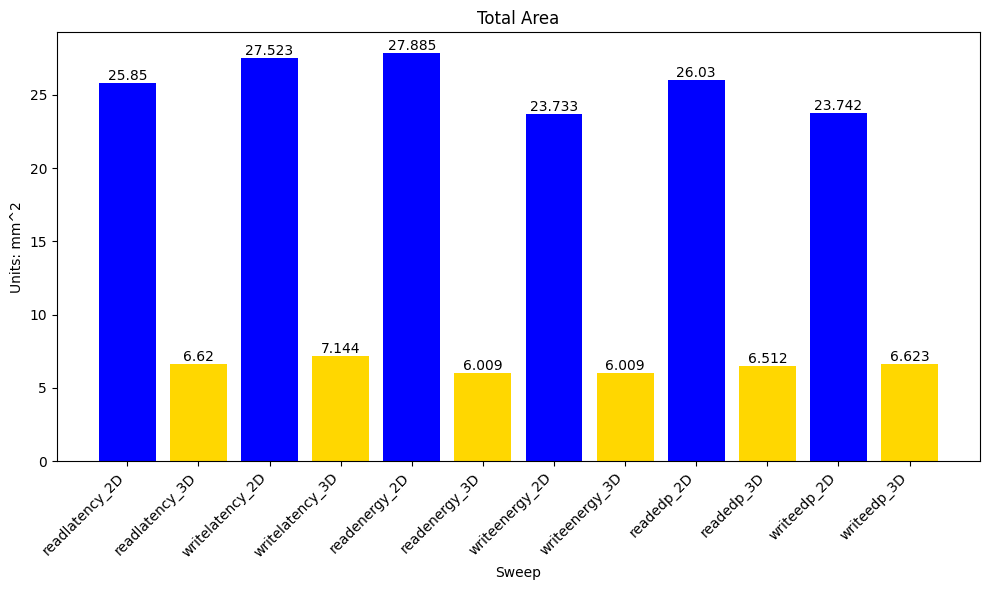

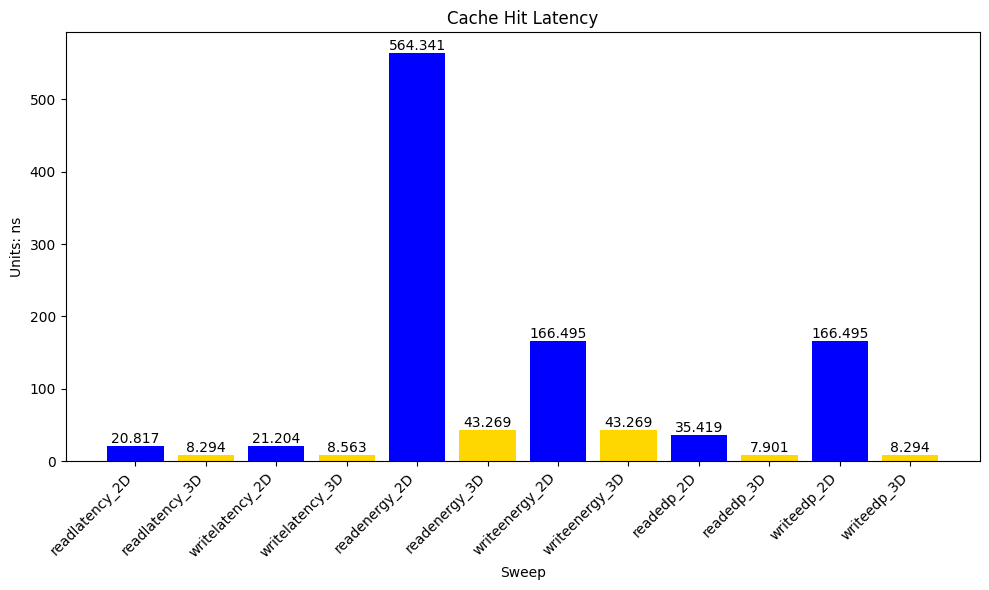

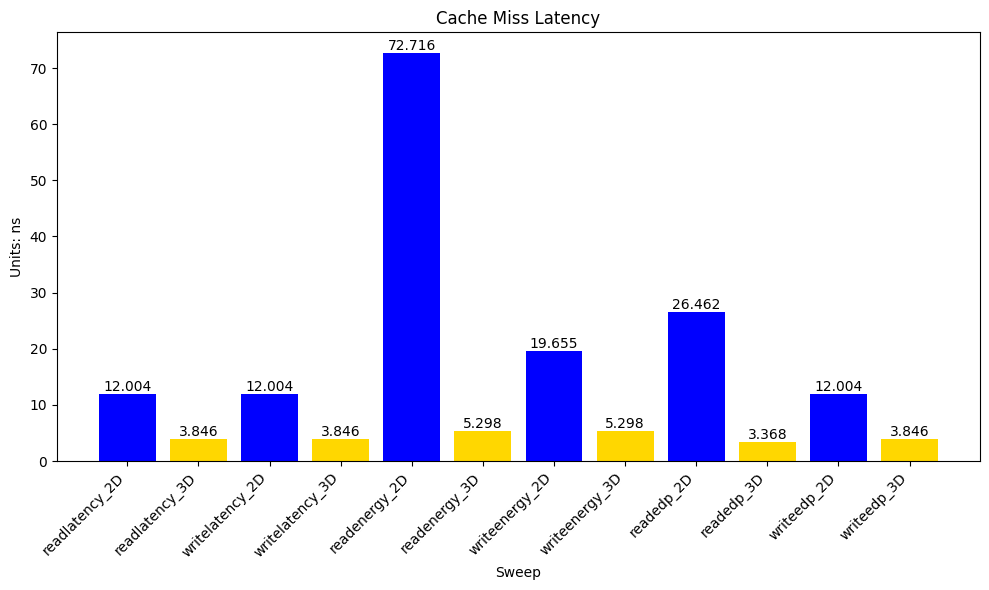

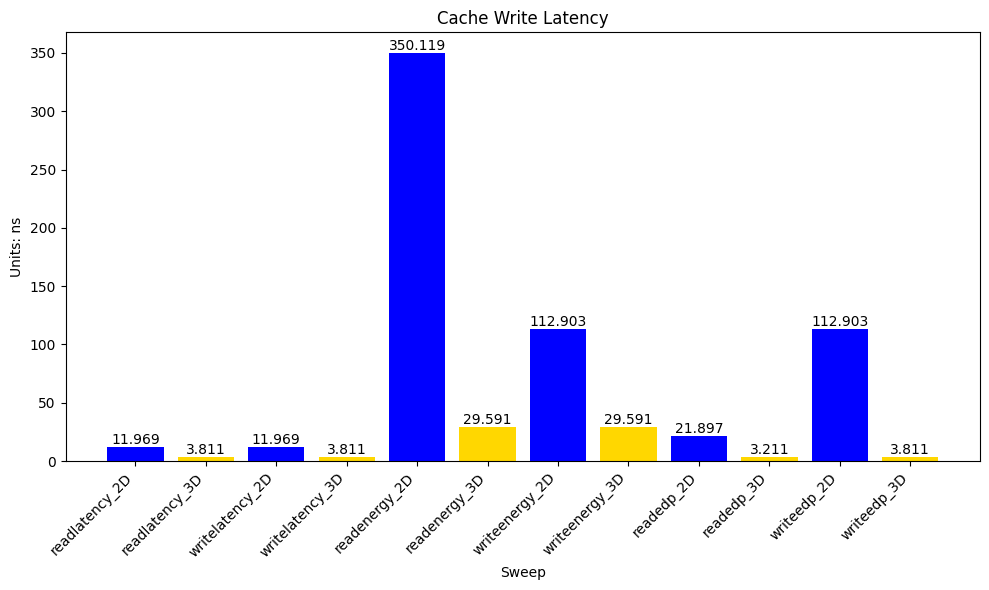

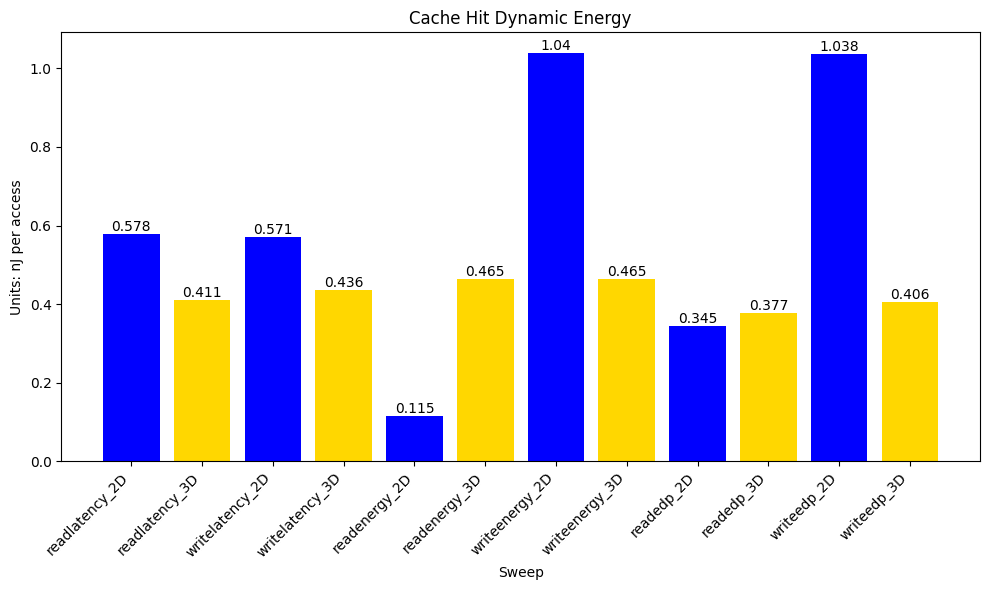

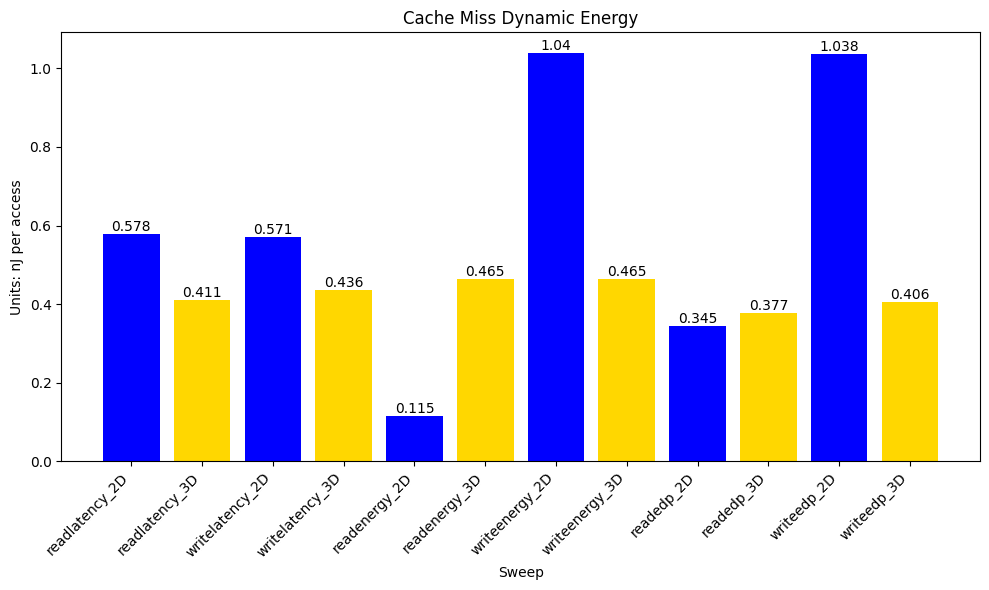

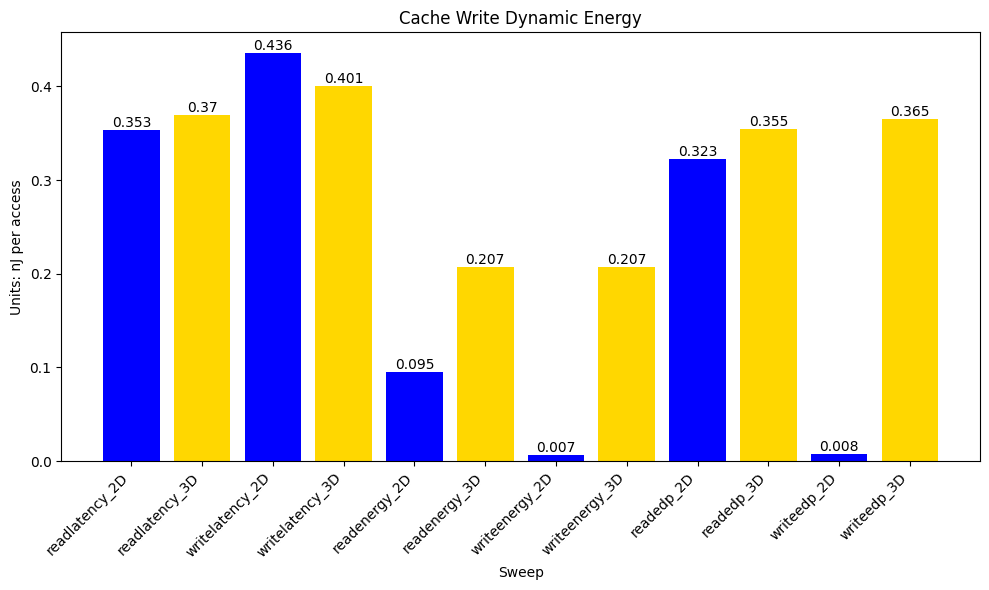

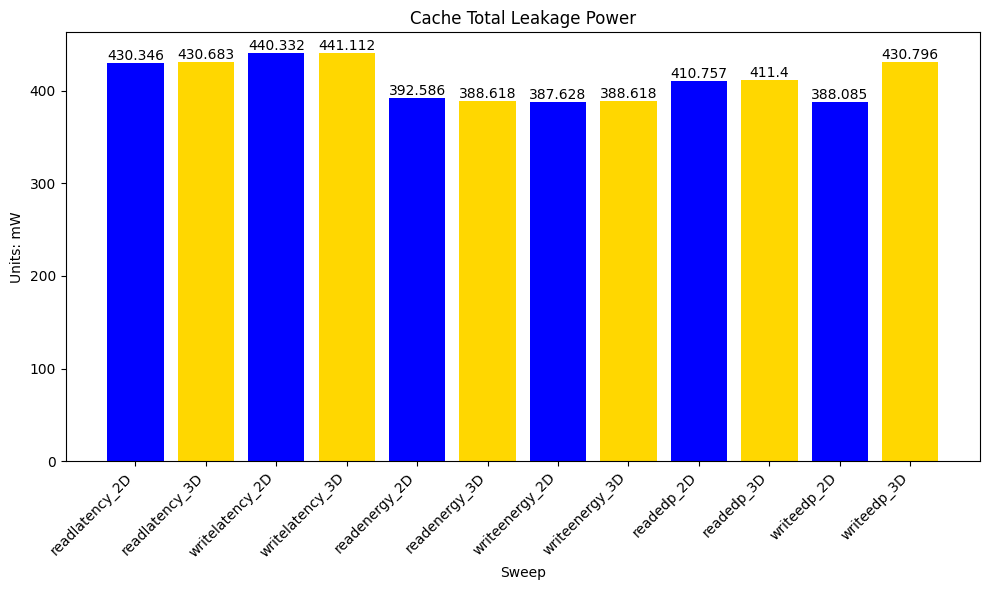

In [17]:
save_figures(numbers_0, units_0, newlabels, "plots")